http://www.gisdeveloper.co.kr/?p=2332

https://vverde.github.io/blob/interactivechoropleth.html

https://medium.com/@kribjer/spatiotemporal-timelapse-visualization-of-covid-19-with-python-f3e8e12693d1

https://cran.r-project.org/web/packages/forecastML/vignettes/grouped_forecast.html

https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet

https://dacon.io/competitions/official/82407/talkboard/400442

# Requirements
The following files are required. They should be located in the same directory as the path variable

* 'KB국민카드_금융빅데이터경진대회_데이터_raw2.csv',
* 'HangJeongDong_ver20210401.geojson',
* '서울행정구역분류_20210701.csv'
The following specific python modules must be installed. General modules commonly used in data science are pandas, numpy, matplotlib, os, etc. these should be installed as well.

In [12]:
# save the directory of the required files as "path"

path='/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/KB/'

Run this code in case matplotlib does not have Korean fonts installed. For google colab, run this cell and then restart runtime and re-run this cell for the Korean fonts to be installed in matplotlib.

In [11]:
# 한글폰트 사용 in colab

%matplotlib inline  

import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [13]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import plotly
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV,  GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import log_loss  
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn.preprocessing import StandardScaler

import imblearn

# make a prediction with a stacking ensemble
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from matplotlib import cm
colors = cm.get_cmap('rainbow')

Importing required modules

In [4]:
import pandas as pd
import numpy as np
import plotly
import datetime
import seaborn as sns
from matplotlib import cm
colors = cm.get_cmap('rainbow')

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip install geopandas

     |████████████████████████████████| 994 kB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 80 kB/s 
     |████████████████████████████████| 6.6 MB 64.8 MB/s 


In [ ]:
import json
import folium
from folium.plugins import TimeSliderChoropleth
from pandas.io.json import json_normalize

import os
import geopandas as gpd
from branca.colormap import linear
from shapely.geometry import Polygon
from branca.colormap import LinearColormap

In [14]:
data=pd.read_csv(path+'KB국민카드_금융빅데이터경진대회_데이터_raw2.csv')

Created a 'date' column as a Timestamp datatype to process time data.

In [15]:
data['date'] = data[['기준년도', '기준년월']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
data['date']=pd.to_datetime(data['date'])



Here is a quick view of the dataset of interest. There are 311624 rows and 16 columns.


In [16]:
data

,기준년도,기준년월,한글시도명,한글시군구명,법정동리명,마케팅업종중분류명,마케팅업종세분류명,마케팅업종세세분류명,성별구분,연령대,신용카드보유여부,체크카드보유여부,회원수,매출건수,순위,date
0,2019,3,경기도,성남시 분당구,구미동,양식,종합양식,종합양식,01.남성,1.20대이하,0,1,112,125,3,2019-03-01
1,2019,3,경기도,성남시 분당구,구미동,양식,종합양식,종합양식,01.남성,1.20대이하,1,0,9,9,3,2019-03-01
2,2019,3,경기도,성남시 분당구,구미동,양식,종합양식,종합양식,01.남성,1.20대이하,1,1,49,56,3,2019-03-01
3,2019,3,경기도,성남시 분당구,구미동,양식,종합양식,종합양식,01.남성,2.30대,0,1,30,32,3,2019-03-01
4,2019,3,경기도,성남시 분당구,구미동,양식,종합양식,종합양식,01.남성,2.30대,1,0,27,31,3,2019-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311620,2021,3,서울특별시,마포구,합정동,한식,면요리,국수/칼국수전문점,02.여성,4.50대,1,0,17,22,5,2021-03-01
311621,2021,3,서울특별시,마포구,합정동,한식,면요리,국수/칼국수전문점,02.여성,4.50대,1,1,42,49,5,2021-03-01
311622,2021,3,서울특별시,마포구,합정동,한식,면요리,국수/칼국수전문점,02.여성,5.60대,0,1,3,3,5,2021-03-01
311623,2021,3,서울특별시,마포구,합정동,한식,면요리,국수/칼국수전문점,02.여성,5.60대,1,0,17,20,5,2021-03-01


# One hot encoding

In [8]:
# converting type of columns to 'category'

from sklearn.preprocessing import OneHotEncoder


# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

onehot_cat = ['법정동리명',	'마케팅업종중분류명',	'마케팅업종세분류명',	'마케팅업종세세분류명'	,'성별구분'	,'연령대', '신용카드보유여부'	,'체크카드보유여부' ,'date'	]

data_cat = data.drop(['기준년도',	'기준년월',	'한글시도명',	'한글시군구명'], axis=1)


data_cat = pd.get_dummies(data_cat, columns = onehot_cat)


# data_cat = data_cat.drop('time')
data_cat 

,회원수,매출건수,순위,법정동리명_개포동,법정동리명_공덕동,법정동리명_구미동,법정동리명_금곡동,법정동리명_논현동,법정동리명_대치동,법정동리명_도곡동,법정동리명_도화동,법정동리명_동교동,법정동리명_망원동,법정동리명_삼성동,법정동리명_삼평동,법정동리명_상수동,법정동리명_상암동,법정동리명_서교동,법정동리명_서현동,법정동리명_성산동,법정동리명_수내동,법정동리명_수서동,법정동리명_신사동,법정동리명_아현동,법정동리명_야탑동,법정동리명_역삼동,법정동리명_연남동,법정동리명_용강동,법정동리명_일원동,법정동리명_정자동,법정동리명_청담동,법정동리명_합정동,마케팅업종중분류명_양식,마케팅업종중분류명_일식,마케팅업종중분류명_한식,마케팅업종세분류명_국/탕/백반류,마케팅업종세분류명_기타고기,마케팅업종세분류명_닭고기,마케팅업종세분류명_돼지고기,마케팅업종세분류명_면요리,...,마케팅업종세세분류명_한정식전문점,마케팅업종세세분류명_해물찜/탕전문점,마케팅업종세세분류명_해장국/감자탕,마케팅업종세세분류명_횟집,성별구분_01.남성,성별구분_02.여성,연령대_1.20대이하,연령대_2.30대,연령대_3.40대,연령대_4.50대,연령대_5.60대,신용카드보유여부_0,신용카드보유여부_1,체크카드보유여부_0,체크카드보유여부_1,date_2019-03-01 00:00:00,date_2019-04-01 00:00:00,date_2019-05-01 00:00:00,date_2019-06-01 00:00:00,date_2019-07-01 00:00:00,date_2019-08-01 00:00:00,date_2019-09-01 00:00:00,date_2019-10-01 00:00:00,date_2019-11-01 00:00:00,date_2019-12-01 00:00:00,date_2020-01-01 00:00:00,date_2020-02-01 00:00:00,date_2020-03-01 00:00:00,date_2020-04-01 00:00:00,date_2020-05-01 00:00:00,date_2020-06-01 00:00:00,date_2020-07-01 00:00:00,date_2020-08-01 00:00:00,date_2020-09-01 00:00:00,date_2020-10-01 00:00:00,date_2020-11-01 00:00:00,date_2020-12-01 00:00:00,date_2021-01-01 00:00:00,date_2021-02-01 00:00:00,date_2021-03-01 00:00:00
0,112,125,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,9,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,49,56,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,30,32,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,27,31,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311620,17,22,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
311621,42,49,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
311622,3,3,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
311623,17,20,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Distributions

Looking at histograms of the data, the distributions of 회원수, 매출건수 and 순위 are all highly skewed. 

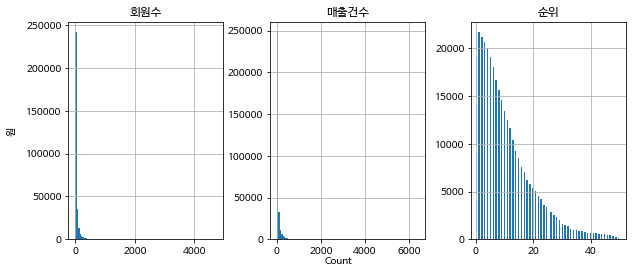

In [17]:
fig, axes = plt.subplots(figsize=(10,4), nrows=1, ncols=3, sharex=False, sharey=False)

data[['회원수', '매출건수', '순위']].hist(bins=100, ax=axes)
ax=plt.gca()

ax.get_xaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
fig.text(0.5, 0.04, 'Count', ha='center')
fig.text(0.04, 0.5, '원', va='center', rotation='vertical')
plt.show()

In [18]:
data[['회원수', '매출건수', '순위']].describe()

,회원수,매출건수,순위
count,311625.000000,311625.000000,311625.000000
mean,49.888844,62.503586,11.211353
std,124.109072,168.925111,9.246757
min,3.000000,3.000000,1.000000
25%,8.000000,10.000000,4.000000
50%,19.000000,22.000000,9.000000
75%,45.000000,54.000000,16.000000
max,4739.000000,6403.000000,50.000000


Since 매출건수 is perhaps the outcome of most interest, we will focus on this attribute. 회원수 and 매출건수 are highly correlated anyways, as to be shown in a scatterplot and correlation matrix.

For 매출건수, Box-cox transformation or log-transformation seems sufficient in making the data less skewed. 

-0.1626131145181734


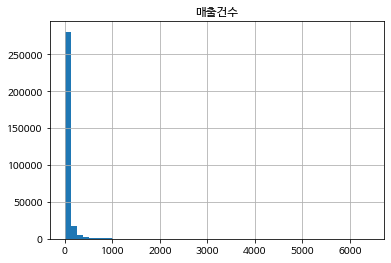

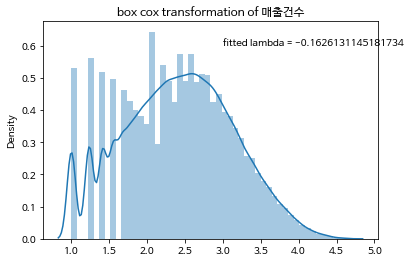

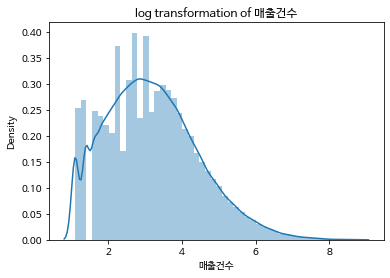

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

plt.figure()
plt.title('매출건수')
data['매출건수'].hist(bins=50)

y,train_fitted_lambda= boxcox(data['매출건수'],lmbda=None)

plt.figure()
plt.title('box cox transformation of 매출건수')
plt.text(3, 0.6, "fitted lambda = {}".format(train_fitted_lambda))
sns.distplot(y)
print(train_fitted_lambda)

plt.figure()
plt.title('log transformation of 매출건수')
sns.distplot(np.log(data['매출건수']))

In [ ]:
data['log(매출건수)']=np.log(data['매출건수'])

count    311625.000000
mean         62.503586
std         168.925111
min           3.000000
25%          10.000000
50%          22.000000
75%          54.000000
max        6403.000000
Name: 매출건수, dtype: float64

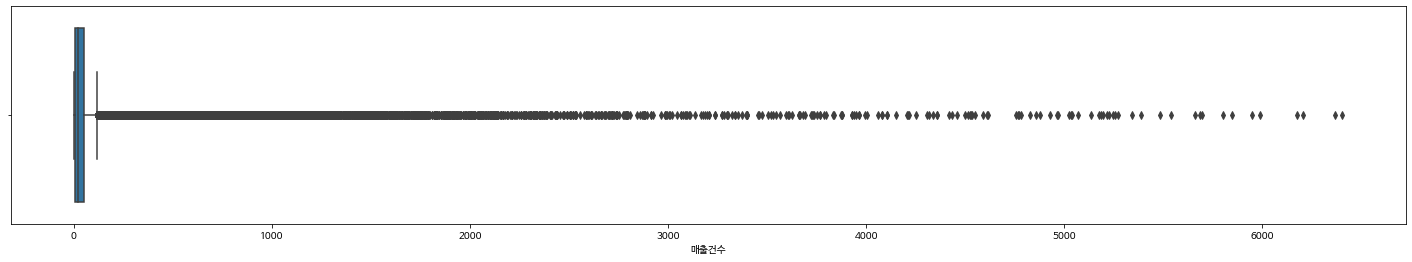

In [ ]:
plt.figure(figsize=(25,4))
sns.boxplot(data['매출건수'])
data['매출건수'].describe()

A box plot of the log transformed data showed that the distribution is less skewed. 

count    311625.000000
mean          3.190999
std           1.249865
min           1.098612
25%           2.302585
50%           3.091042
75%           3.988984
max           8.764522
Name: log(매출건수), dtype: float64

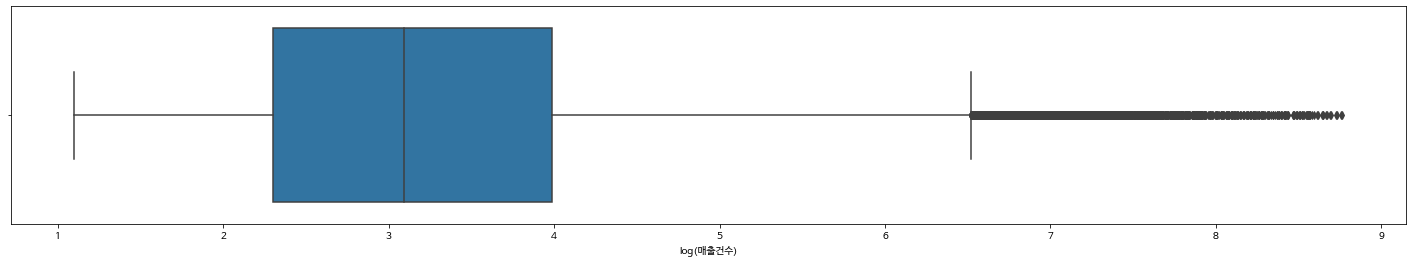

In [ ]:
plt.figure(figsize=(25,4))
sns.boxplot(data['log(매출건수)'])
data['log(매출건수)'].describe()

월 매출건수가 100 이하인 점들이 대다수 였다. (n=269921)

Since the data is highly skewed for 매출건수, it could be better to stratify the data into different levels of 매출건수. Sales less than 100 were the most abundant, so this was saved as the a seperate dataframe. The same goes for levels 100 to 500, 500 to 2000, and over 2000. The statistics and seperate box plots of the dataframes at different levels are shown in the following.

Count of sales less than 100 was 269921, which is the majority of the data.



In [27]:
df_under100 = data_cat[data_cat['매출건수']<100]
df_over100_under500 = data_cat[(data_cat['매출건수']>=100) & (data['매출건수']<500)]
df_over500_under2000 = data_cat[(data_cat['매출건수']>=500) & (data['매출건수']<2000)]

df_under2000 = data_cat[data_cat['매출건수']<2000]
df_over2000 = data_cat[data_cat['매출건수']>=2000]

In [68]:
print(df_under2000.shape)
print(df_over2000.shape)

(311224, 141)
(401, 141)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass t


 ---매출건수 >100--- 
 count    269921.000000
mean         25.807736
std          22.736552
min           3.000000
25%           8.000000
50%          18.000000
75%          36.000000
max          99.000000
Name: 매출건수, dtype: float64

 ---100 <= 매출건수 < 500--- 
 count    36553.000000
mean       199.017947
std         95.540804
min        100.000000
25%        125.000000
50%        165.000000
75%        245.000000
max        499.000000
Name: 매출건수, dtype: float64

 ---500 <= 매출건수 < 2000--- 
 count    4750.000000
mean      849.848632
std       347.161460
min       500.000000
25%       589.000000
50%       720.000000
75%      1001.000000
max      1999.000000
Name: 매출건수, dtype: float64

 ---매출건수 >=2000--- 
 count     401.000000
mean     2992.882793
std      1017.558143
min      2006.000000
25%      2213.000000
50%      2613.000000
75%      3506.000000
max      6403.000000
Name: 매출건수, dtype: float64

 ---매출건수 Total--- 
 count    311625.000000
mean         62.503586
std         168.925111
min    

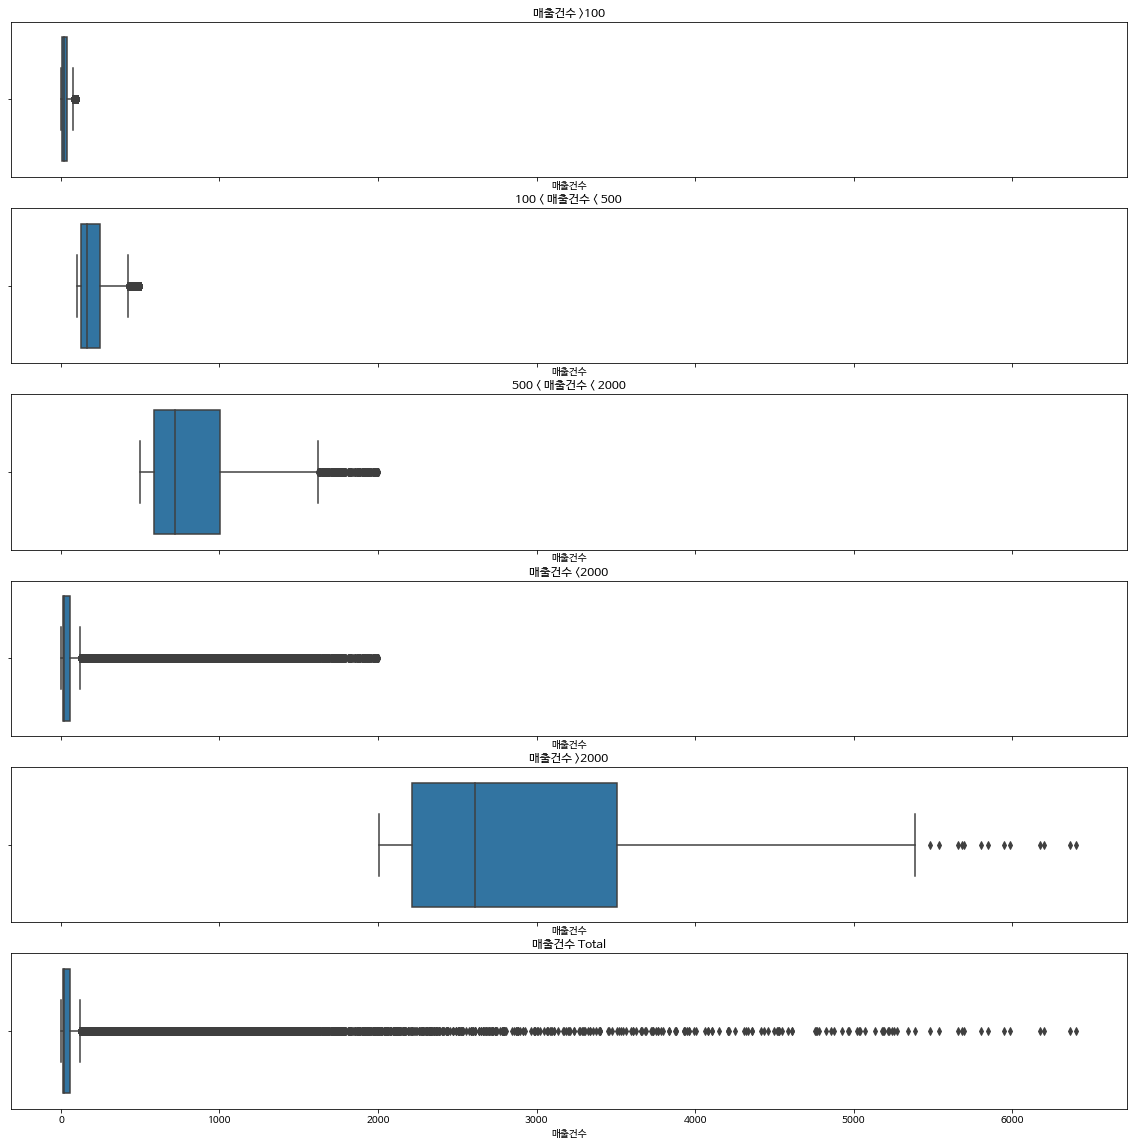

In [28]:
f, axes = plt.subplots(6, 1, figsize=(20,20), sharex=True)
ax1=sns.boxplot(df_under100['매출건수'], ax=axes[0])
ax2=sns.boxplot(df_over100_under500['매출건수'], ax=axes[1])
ax3=sns.boxplot(df_over500_under2000['매출건수'], ax=axes[2])
ax4=sns.boxplot(df_under2000['매출건수'], ax=axes[3])
ax5=sns.boxplot(df_over2000['매출건수'], ax=axes[4])
ax6=sns.boxplot(data['매출건수'], ax=axes[5])


ax1.title.set_text('매출건수 >100')
ax2.title.set_text('100 < 매출건수 < 500')
ax3.title.set_text('500 < 매출건수 < 2000')
ax4.title.set_text('매출건수 <2000')
ax5.title.set_text('매출건수 >2000')
ax6.title.set_text('매출건수 Total')

print('\n ---매출건수 >100--- \n', df_under100['매출건수'].describe())
print('\n ---100 <= 매출건수 < 500--- \n', df_over100_under500['매출건수'].describe())
print('\n ---500 <= 매출건수 < 2000--- \n', df_over500_under2000['매출건수'].describe())
print('\n ---매출건수 >=2000--- \n', df_over2000['매출건수'].describe())
print('\n ---매출건수 Total--- \n', data['매출건수'].describe())

As mentioned before, a scatterplot of 회원수 and 매출건수 show that these two attributes are highly correlated. This makes sense larger membership size of a resteraunt usually means larger sales for that resteraunt. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0, 6000, 'pearson r =0.99')

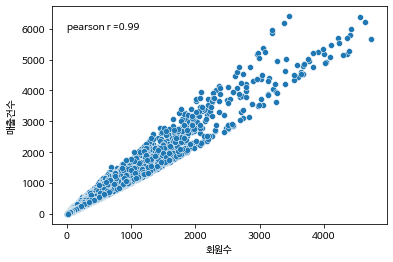

In [19]:
from scipy import stats

sns.scatterplot(data['회원수'], data['매출건수'])
pearsonr = stats.pearsonr(data['회원수'], data['매출건수'])[0]
plt.text(x=0, y=6000, s="pearson r ={:.2f}".format(pearsonr))


Samples with higher 매출건수 were placed in higher ranks.

However, a sample who placed higher in 순위 does not necessarily mean that sales volume 매출건수 was higher. The minimum 매출건수 for a sample 순위 ranked 1 is only 3. The same logic applies to 회원수. 

This means that 순위 and 


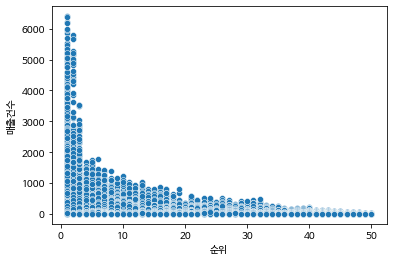

In [ ]:
sns.scatterplot(data['순위'], data['매출건수'])

# Correlation Plots 상관계수 분석

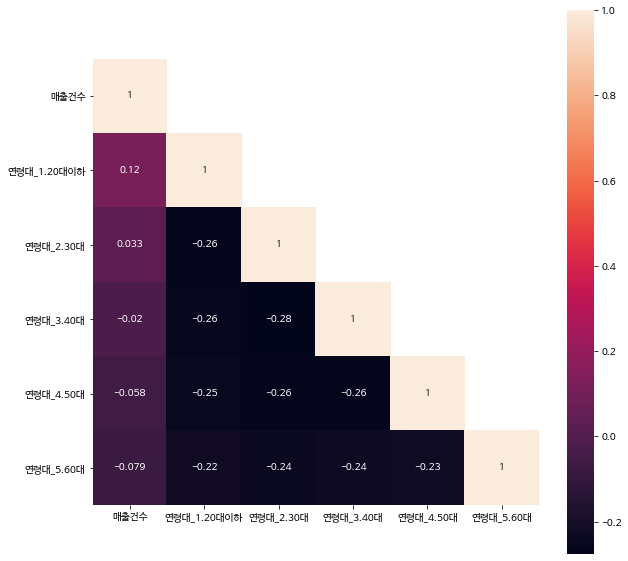

In [ ]:
df1 = data[['연령대','매출건수']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

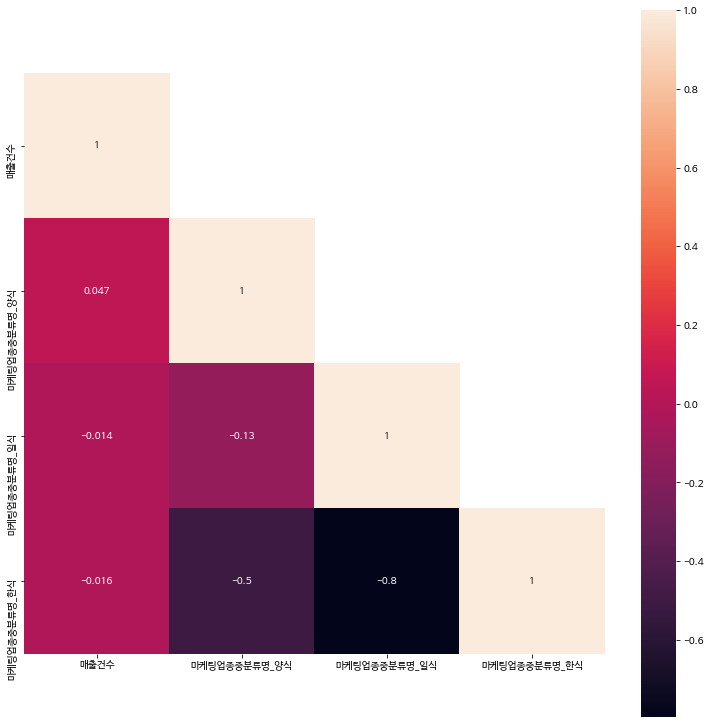

In [ ]:
df1 = data[['마케팅업종중분류명','매출건수']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(13,13)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

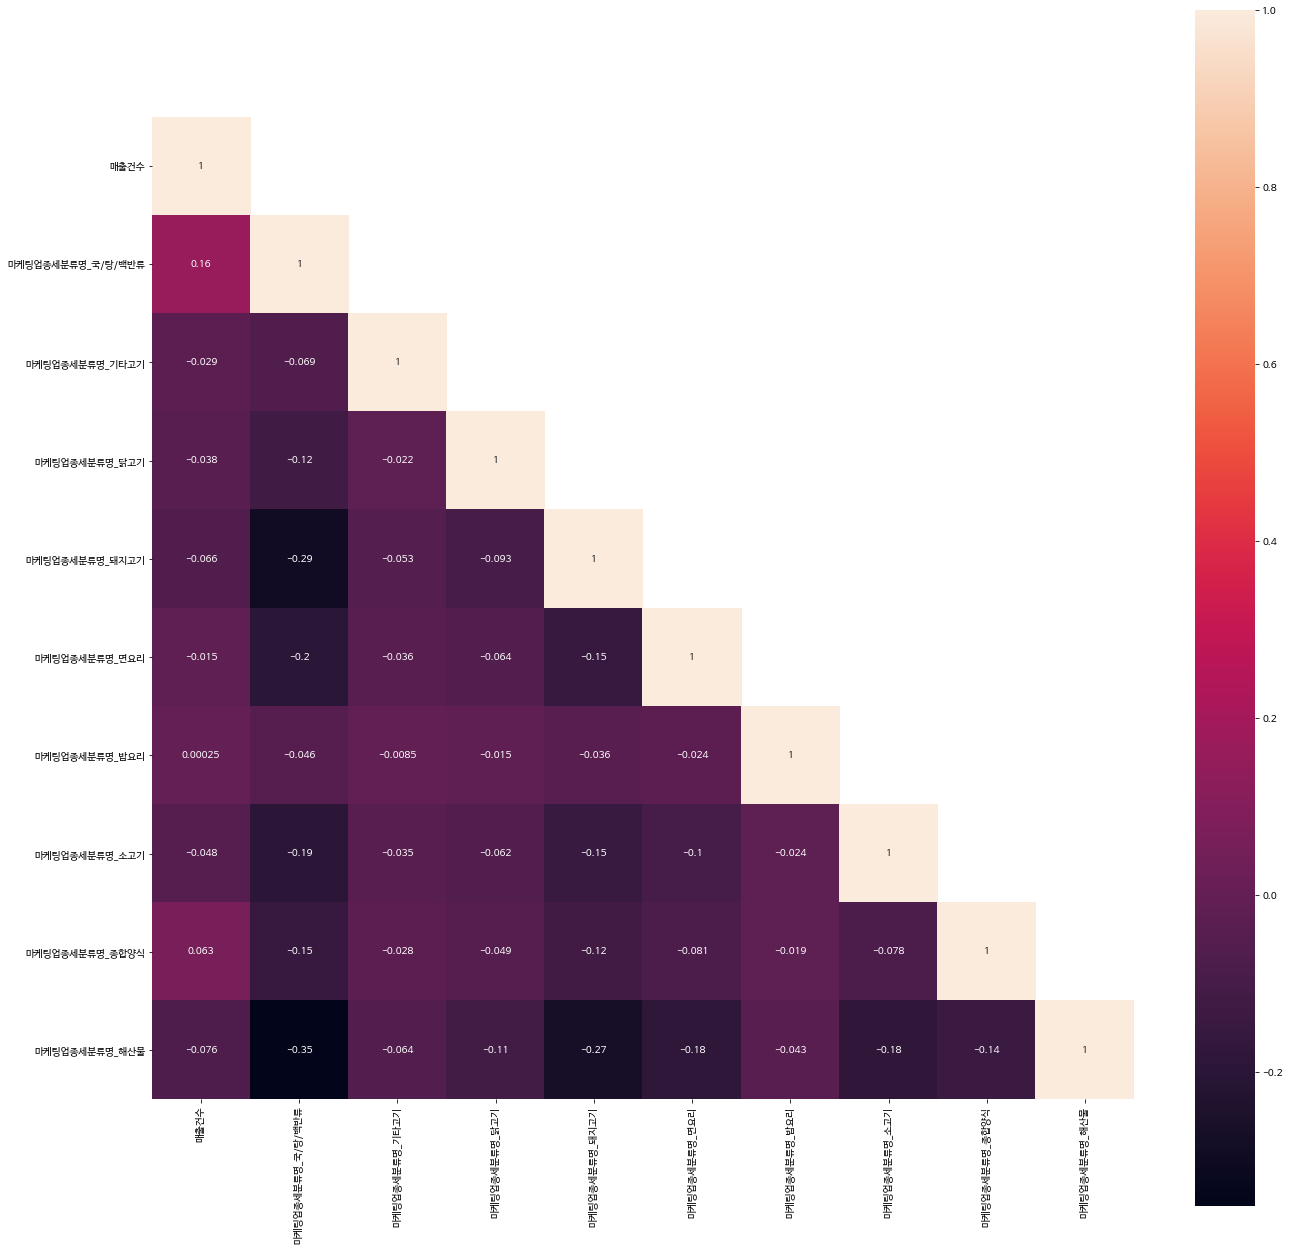

In [ ]:
df1 = data[['마케팅업종세분류명','매출건수']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(22,22)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

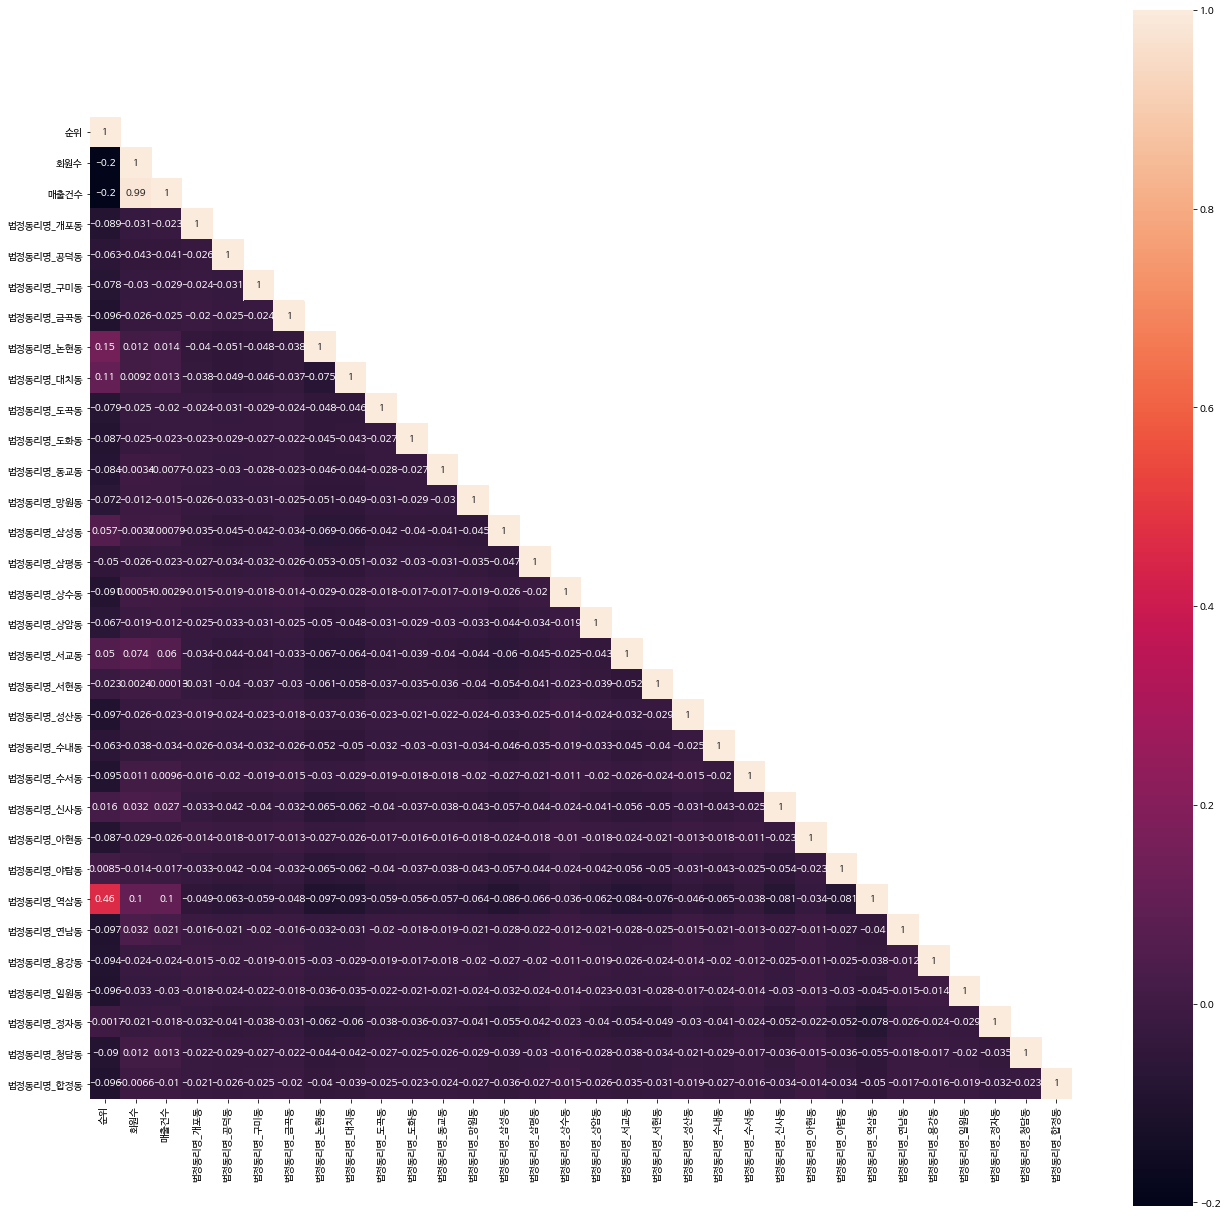

In [ ]:
df1 = data[['법정동리명','순위','회원수','매출건수']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(22,22)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

#카드보유

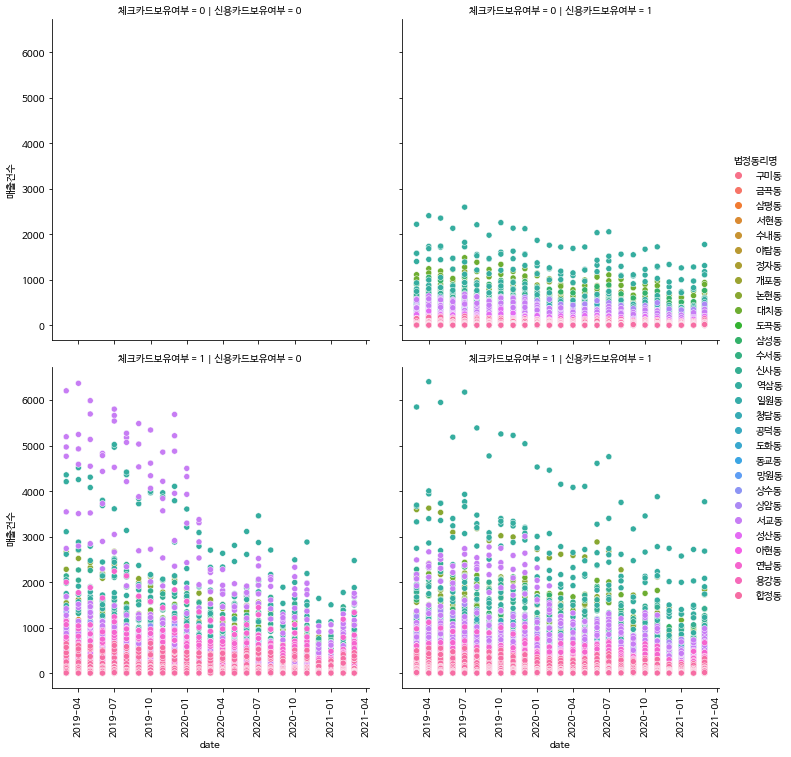

In [ ]:
g=sns.relplot(data=data, x="date", y="매출건수", hue="법정동리명", col="신용카드보유여부", row="체크카드보유여부")
g.set_xticklabels(rotation=90)
plt.show()

# Dot Plot by category

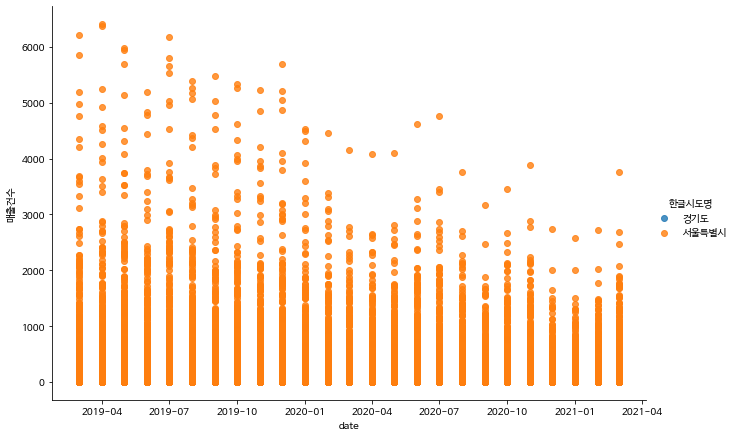

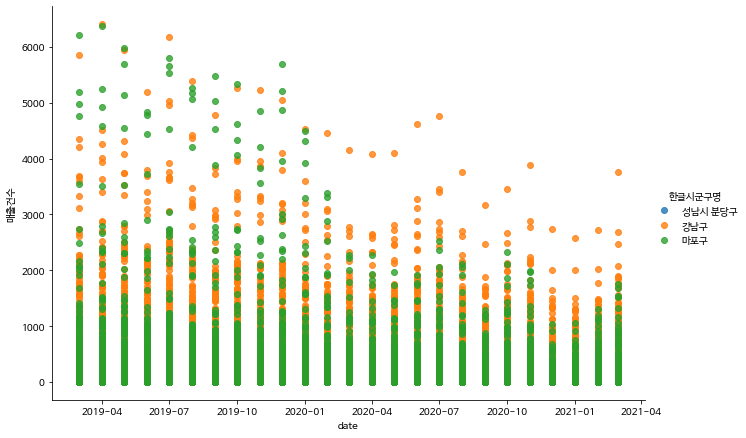

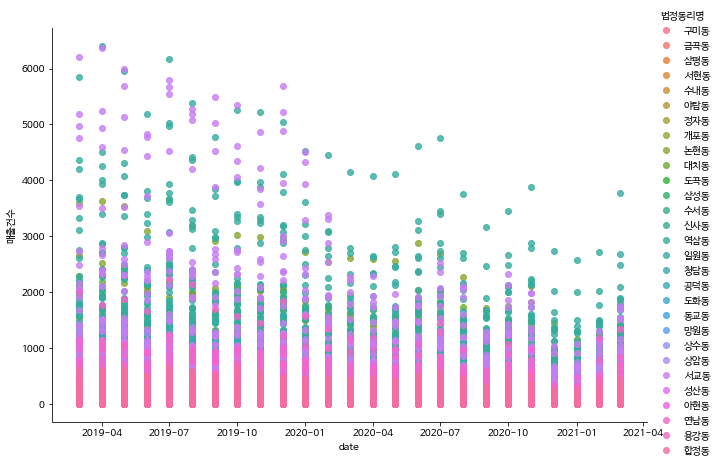

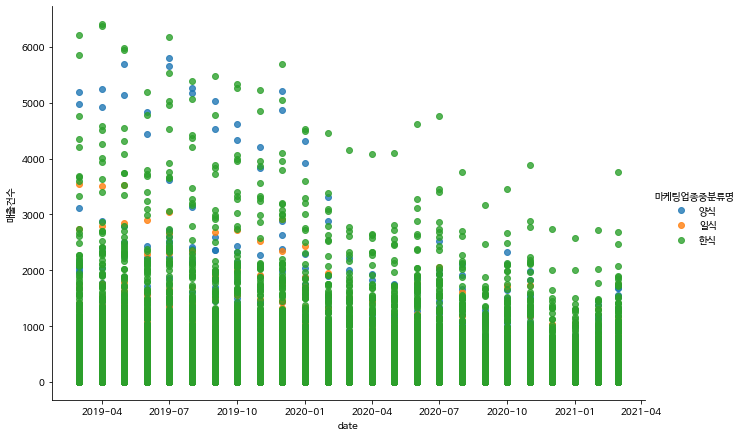

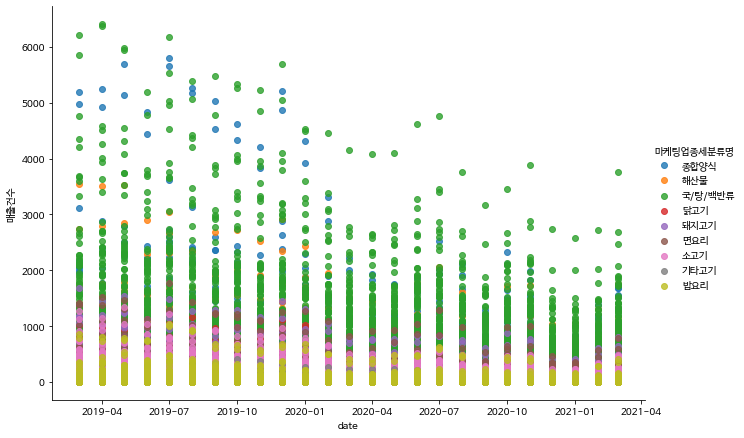

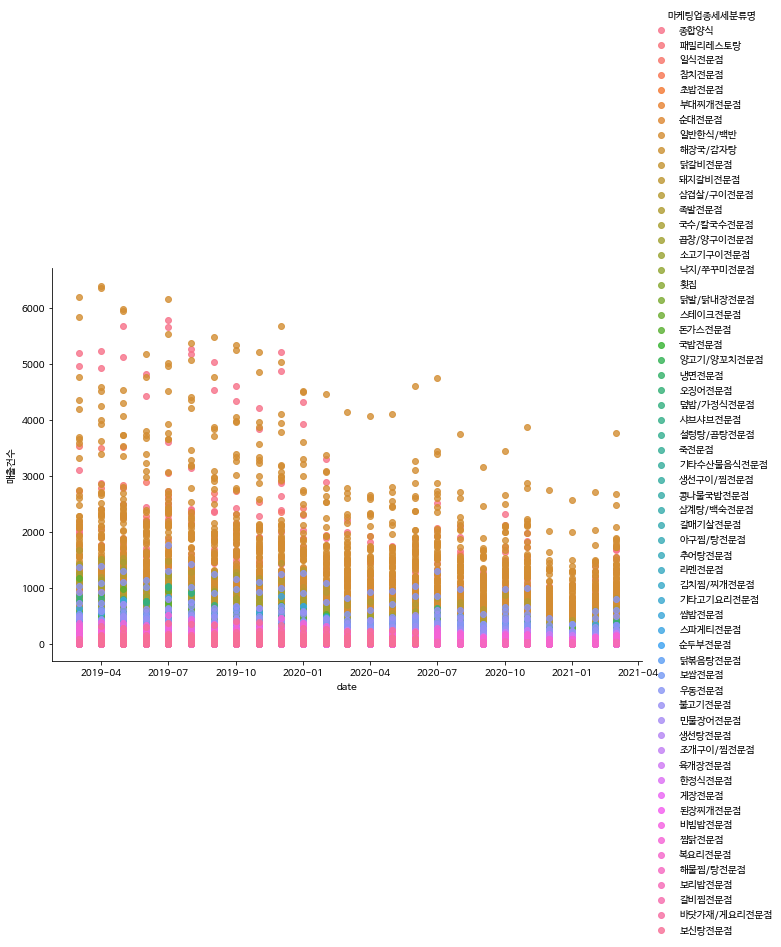

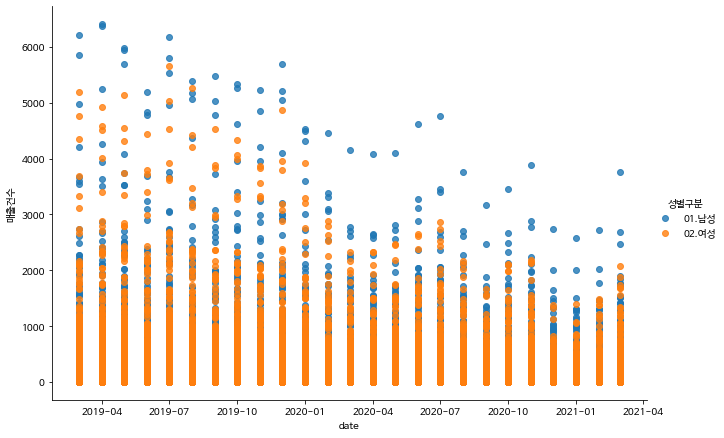

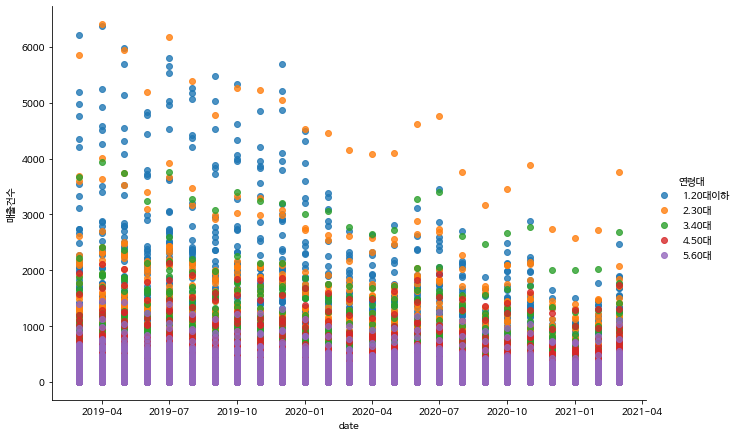

In [ ]:
for i, name in enumerate(cat_features):
  g = sns.lmplot(x='date', y='매출건수', data=data, hue=name, fit_reg=False, height=6, aspect=1.5)

# Data 매출건수<2000

In [30]:
col_all = list(data_cat.columns)
col_features = list(data_cat.columns)

LABEL = '매출건수'
SEED =42

col_features.remove(LABEL)


In [31]:
X=df_under2000.loc[:, df_under2000.columns != LABEL]
y=df_under2000[LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= SEED)
X_train = pd.DataFrame(data=X_train,columns=X.columns )
y_train= pd.DataFrame(data=y_train,columns=[LABEL])
y_test= pd.DataFrame(data=y_test,columns=[LABEL])


#train = pd.DataFrame(prepro.transform(X_train),columns = col_train)
#test  = pd.DataFrame(prepro_test.transform(X_test),columns = col_train_bis)

print('Training set dimensions X, y: ' + str(X_train.shape) + ' ' +str(y_train.shape))
print('Test set dimensions X, y: ' + str(X_test.shape) + ' '+ str(y_test.shape))

Training set dimensions X, y: (217856, 140) (217856, 1)
Test set dimensions X, y: (93368, 140) (93368, 1)


In [32]:
scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train  = scaler.fit_transform(y_train)
y_test  = scaler.fit_transform(y_test)

X_train = pd.DataFrame(X_train,columns = col_features)
X_test  = pd.DataFrame(X_test,columns = col_features)

y_train = pd.DataFrame(y_train,columns = [LABEL])
y_test  = pd.DataFrame(y_test,columns = [LABEL])

## xgb regressor

### hyperparamter tuning

**Best score in Hyperparamter Tuning**: 0.9813351873799447

**Best parameters in Hyperparamter Tuning**: 

'colsample_bytree': 0.7, 

'learning_rate': 0.07, 

'max_depth': 7,

'min_child_weight': 4, 

'n_estimators': 1000, 
'nthread': 4, 

'objective': 'reg:linear', 

'silent': 1, 

'subsample': 0.7

In [ ]:
import time

seed=3
# create a default XGBoost classifier
model = xgboost.XGBRegressor(tree_method = "gpu_hist")

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4,5,6],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,700,1000]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)





Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 20.9min finished


0.9813351873799447
{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [33]:
import xgboost
from sklearn.metrics import mean_squared_error
from numpy import absolute

kwargs= {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

model = xgboost.XGBRegressor(tree_method = "gpu_hist")
model.set_params(**kwargs)
model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train,scoring='neg_mean_squared_error',cv=10, n_jobs=-1)
scores = absolute(scores)
print('Training Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
model.fit(X_train, y_train, eval_metric=['mae'])

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_pred,y_test)
print(np.sqrt(mse))


print(" Test MSE: %.2f" % mse)

print("Test RMSE: %.2f" % (mse**(1/2.0)))

Training Mean MAE: 0.007 (0.001)
0.12767858769946028
 Test MSE: 0.02
Test RMSE: 0.13


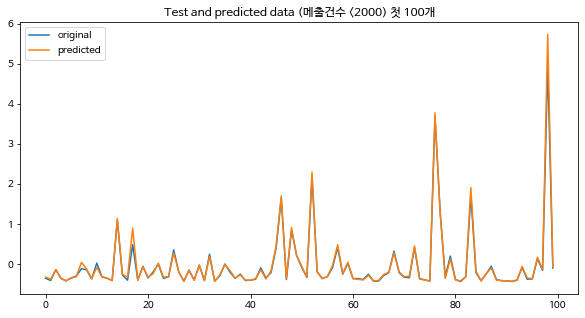

In [38]:
#Finally, we'll visualize the original and predicted test data in a plot to compare visually.
plt.figure(figsize=(10,5))

x_ax = range(len(y_test[0:100]))
plt.plot(x_ax[0:100], y_test[0:100], label="original")
plt.plot(x_ax[0:100], y_pred[0:100], label="predicted")
plt.title("Test and predicted data (메출건수 <2000) 첫 100개")
plt.legend()
plt.show()

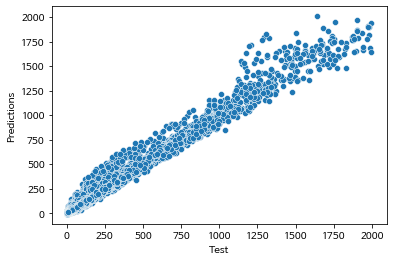

In [35]:
predictions = scaler.inverse_transform(y_pred) #.reshape(93488,1)
reality = scaler.inverse_transform(np.array(y_test['매출건수']))

concatenated = pd.DataFrame({'Test': reality, 'Predictions': list(predictions)}, columns=['Test', 'Predictions'])



sns.scatterplot(x='Test', y="Predictions", data=concatenated,
                #style='dataset'
                )
plt.show()

### Feature Importance

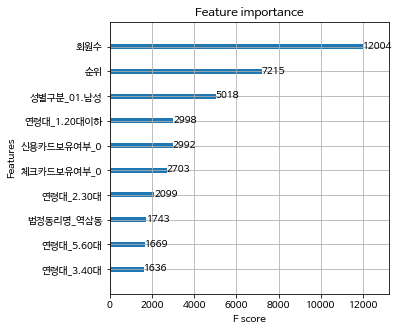

In [37]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_importance(model, ax=ax, max_num_features=10)
plt.show()

# Data 매출건수 >2000

In [40]:
X=df_over2000.loc[:, df_over2000.columns != LABEL]
y=df_over2000[LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= SEED)
X_train = pd.DataFrame(data=X_train,columns=X.columns )
y_train= pd.DataFrame(data=y_train,columns=[LABEL])
y_test= pd.DataFrame(data=y_test,columns=[LABEL])


#train = pd.DataFrame(prepro.transform(X_train),columns = col_train)
#test  = pd.DataFrame(prepro_test.transform(X_test),columns = col_train_bis)

print('Training set dimensions X, y: ' + str(X_train.shape) + ' ' +str(y_train.shape))
print('Test set dimensions X, y: ' + str(X_test.shape) + ' '+ str(y_test.shape))

Training set dimensions X, y: (280, 140) (280, 1)
Test set dimensions X, y: (121, 140) (121, 1)


In [41]:
scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train  = scaler.fit_transform(y_train)
y_test  = scaler.fit_transform(y_test)

X_train = pd.DataFrame(X_train,columns = col_features)
X_test  = pd.DataFrame(X_test,columns = col_features)

y_train = pd.DataFrame(y_train,columns = [LABEL])
y_test  = pd.DataFrame(y_test,columns = [LABEL])

## xgb regressor

### hyperparameter tuning

**Best score in Hyperparamter Tuning**: 0.9813351873799447

**Best parameters in Hyperparamter Tuning**: 

'colsample_bytree': 0.7, 

'learning_rate': 0.03, 

'max_depth': 5,

'min_child_weight': 6, 

'n_estimators': 1000, 
'nthread': 4, 

'objective': 'reg:linear', 

'silent': 1, 

'subsample': 0.7


In [ ]:
import time

seed=3
# create a default XGBoost classifier
model = xgboost.XGBRegressor(tree_method = "gpu_hist")

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4,5,6],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,700,1000]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)





Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  6.7min finished


0.971099156109507
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}


In [42]:
import xgboost
from sklearn.metrics import mean_squared_error
from numpy import absolute

kwargs= {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

model = xgboost.XGBRegressor(tree_method = "gpu_hist")
model.set_params(**kwargs)
model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train,scoring='neg_mean_squared_error',cv=10, n_jobs=-1)
scores = absolute(scores)
print('Training Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
model.fit(X_train, y_train, eval_metric=['mae'])

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_pred,y_test)
print(np.sqrt(mse))


print(" Test MSE: %.2f" % mse)

print("Test RMSE: %.2f" % (mse**(1/2.0)))

Training Mean MAE: 0.022 (0.007)
0.2279189992557398
 Test MSE: 0.05
Test RMSE: 0.23


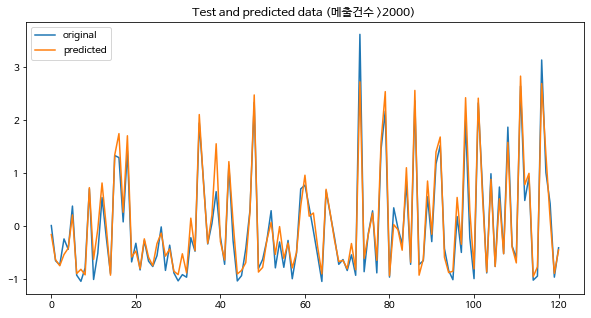

In [43]:
#Finally, we'll visualize the original and predicted test data in a plot to compare visually.
plt.figure(figsize=(10,5))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Test and predicted data (메출건수 >2000) ")
plt.legend()
plt.show()

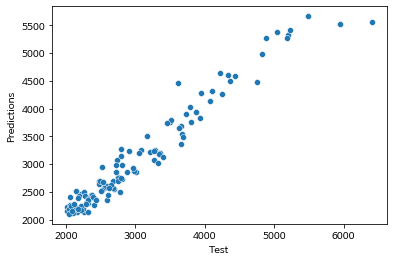

In [44]:
predictions = scaler.inverse_transform(y_pred) #.reshape(93488,1)
reality = scaler.inverse_transform(np.array(y_test['매출건수']))

concatenated = pd.DataFrame({'Test': reality, 'Predictions': list(predictions)}, columns=['Test', 'Predictions'])



sns.scatterplot(x='Test', y="Predictions", data=concatenated,
                #style='dataset'
                )
plt.show()

### Feature Importance

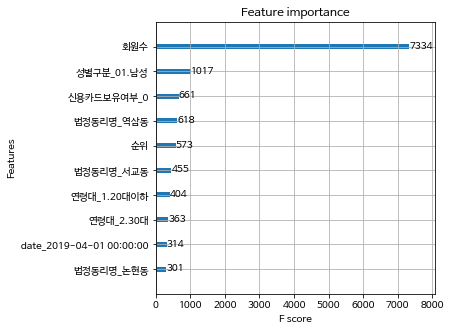

In [46]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_importance(model, ax=ax, max_num_features=10)
plt.show()

# 회원수 별로 나눈 결과

count    311625.000000
mean         49.888844
std         124.109072
min           3.000000
25%           8.000000
50%          19.000000
75%          45.000000
max        4739.000000
Name: 회원수, dtype: float64

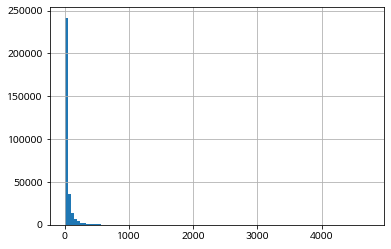

In [50]:
data_cat['회원수'].hist(bins=100)
data_cat['회원수'].describe()

In [67]:
df_member_u100 = data_cat[data_cat['회원수']<100]
df_member_o100 = data_cat[data_cat['회원수']>=100]
print(df_member_u100.shape)
print(df_member_o100.shape)

(278142, 141)
(33483, 141)


In [59]:
X=df_member_o100.loc[:, df_member_o100.columns != LABEL]
y=df_member_o100[LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state= SEED)
X_train = pd.DataFrame(data=X_train,columns=X.columns )
y_train= pd.DataFrame(data=y_train,columns=[LABEL])
y_test= pd.DataFrame(data=y_test,columns=[LABEL])


#train = pd.DataFrame(prepro.transform(X_train),columns = col_train)
#test  = pd.DataFrame(prepro_test.transform(X_test),columns = col_train_bis)

print('Training set dimensions X, y: ' + str(X_train.shape) + ' ' +str(y_train.shape))
print('Test set dimensions X, y: ' + str(X_test.shape) + ' '+ str(y_test.shape))

Training set dimensions X, y: (23438, 140) (23438, 1)
Test set dimensions X, y: (10045, 140) (10045, 1)


In [60]:
scaler = StandardScaler()
X_train  = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)
y_train  = scaler.fit_transform(y_train)
y_test  = scaler.fit_transform(y_test)

X_train = pd.DataFrame(X_train,columns = col_features)
X_test  = pd.DataFrame(X_test,columns = col_features)

y_train = pd.DataFrame(y_train,columns = [LABEL])
y_test  = pd.DataFrame(y_test,columns = [LABEL])

In [61]:
import xgboost
from sklearn.metrics import mean_squared_error
from numpy import absolute

kwargs= {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}

model = xgboost.XGBRegressor(tree_method = "gpu_hist")
model.set_params(**kwargs)
model.fit(X_train, y_train)

scores = cross_val_score(model, X_train, y_train,scoring='neg_mean_squared_error',cv=10, n_jobs=-1)
scores = absolute(scores)
print('Training Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
model.fit(X_train, y_train, eval_metric=['mae'])

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_pred,y_test)
print(np.sqrt(mse))


print(" Test MSE: %.2f" % mse)

print("Test RMSE: %.2f" % (mse**(1/2.0)))

Training Mean MAE: 0.008 (0.003)
0.11209856139693136
 Test MSE: 0.01
Test RMSE: 0.11


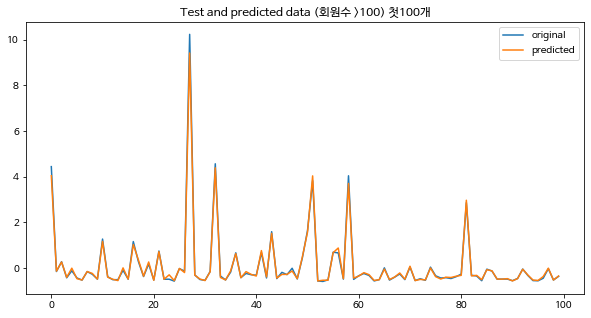

In [65]:
#Finally, we'll visualize the original and predicted test data in a plot to compare visually.
plt.figure(figsize=(10,5))

x_ax = range(len(y_test[0:100]))
plt.plot(x_ax[0:100], y_test[0:100], label="original")
plt.plot(x_ax[0:100], y_pred[0:100], label="predicted")
plt.title("Test and predicted data (회원수 >100) 첫100개")
plt.legend()
plt.show()

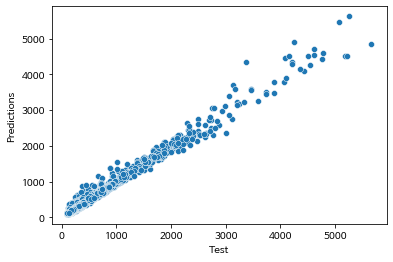

In [63]:
predictions = scaler.inverse_transform(y_pred) #.reshape(93488,1)
reality = scaler.inverse_transform(np.array(y_test['매출건수']))

concatenated = pd.DataFrame({'Test': reality, 'Predictions': list(predictions)}, columns=['Test', 'Predictions'])



sns.scatterplot(x='Test', y="Predictions", data=concatenated,
                #style='dataset'
                )
plt.show()

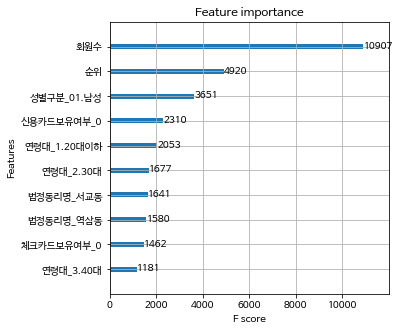

In [64]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(5,5))
plot_importance(model, ax=ax, max_num_features=10)
plt.show()

# Map visualization

## 동를 기준으로 평균한 매출건수를 지도로 시각화

In [ ]:
 def color_scale(data, column):
  """

  Input: dongmean data , column
  Output: color data with only that column in dongmean data, and the colormap (cmap)

  Define a color map in terms of each dong’s column mean for each year, then map the colors to a predefined color map. 

  To create the colormap, we calculate the maximum and minimum values over all the timeseries. 
  Then, convert datetime to U10 with pandas.DatetimeIndex() and astype()
  reference: https://jingwen-z.github.io/how-to-draw-a-variety-of-maps-with-folium-in-python/
  """
  data = data[['행정구역코드', 'date', column]].dropna()
 # data[column] = data[column].fillna(0)
  max_colour = max(data[column])
  min_colour = min(data[column])
  q3_colour = data[column].quantile(0.75)
  q2_colour = data[column].quantile(0.5)
  q1_colour = data[column].quantile(0.25)
  cmap = LinearColormap(
                      #colors=['gray', 'beige', 'yellow', 'orange', 'red', 'purple'], 
                      colors=['gray', 'yellow', 'red'], 
                      index=[0, min_colour,  max_colour],
                      vmin = min_colour, vmax = max_colour,
                      #scale_width = 800, scale_height=20
                      ).to_step(6)

  #cmap = linear.YlOrRd_09.scale(min_colour, max_colour) 
  # cmap = LinearColormap(['yellow','red'], vmin = min_colour, vmax = max_colour)
  
  data['colour'] = data[column].map(cmap)

  data['date_sec'] = pd.to_datetime(data['date']).astype(int) / 10**9
  data['date_sec'] = data['date_sec'].astype(int).astype(str)

  return data, cmap
  print(column, 'min_colour={} max_colour={}'.format(min_colour, max_colour))

In [ ]:
# style_dictionary function required for time slider
def style_dictionary(data):

  """
  Input: dongmean_polygon
  Output: style_dict

  Note that dongmean has 2130 rows while dongmean_polygon 21302115. This is because there are some 법정동 in our data that is not in the geojson. 
  since the geopandas df (행정구역_gdf) was merged on dongmean_polygon, and the index must match for the style dictionary, use dongmean_polygon.

  Creating the style dictionary
  In the color map, Color is set, but opacity is not set here, so its just 0.7. If opacity needs to be set, 
  Do the same approach as color in the colorm_scale() function: calculate the max/min of the opacity column, so that we can map that column into a range [0,1]
  """
  구역_list = data['행정구역코드'].unique().tolist()
  구역_idx = range(len(구역_list))

  style_dict = {}
  for i in 구역_idx:
      구역 = 구역_list[i]
      result = data[data['행정구역코드'] == 구역]
      inner_dict = {}
      for _, r in result.iterrows():
          inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
      style_dict[str(i)] = inner_dict
  
  return style_dict

In [ ]:
# function to make Time slider maps
def Time_slider_all(mapdata, data, column, metric): 

  #column=str(column)
  directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/KB/dong{0}/'.format(column)

  if not os.path.exists(directory):
    os.makedirs(directory)
  
  data, cmap = color_scale(data, column)
  style_dict = style_dictionary(data)

  map = folium.Map(location=[37.5502, 126.982], zoom_start=11, max_bounds=True)

  g = TimeSliderChoropleth(
      mapdata,
      styledict=style_dict, overlay = True
  ).add_to(map)

  map.add_child(cmap)

  if metric=='mean':
    cmap.caption = '평균 {0}'.format(column) + '____________'+  'Grey: No Data ; Yellow: Minimum'
  elif metric=='sum':
    cmap.caption = '총 {0}'.format(column) + '____________'+  'Grey: No Data ; Yellow: Minimum'
  map.add_child(folium.map.LayerControl())
  if metric=='mean':
    map.save(directory+'plot_dong_timeslider_mean{0}'.format(column))
  elif metric=='sum':
    map.save(directory+'plot_dong_timeslider_sum{0}'.format(column))
  

  display(map)

In [ ]:
# Execute function
numcol_list = ['회원수',	'매출건수']

for column_name in numcol_list:
  Time_slider_all(행정구역_gdf, dongmean_polygon, column_name, 'mean')
  Time_slider_all(행정구역_gdf, dongsum_polygon, column_name, 'sum')

In [ ]:
times= sorted(c['date'].unique())

appended_data_dong={}
for i, date in enumerate(times):
  dongmean총지출=c[c['date']==date ].groupby('행정구역코드')['매출건수'].mean().reset_index()
  dongmean총지출['행정구역코드']=dongmean총지출['행정구역코드'].astype(str)
  appended_data_dong[date] = dongmean총지출


In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/KB/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '매출건수'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 매출건수',
                nan_fill_color = "Grey",
                threshold_scale=list(range(0, 176,25)), # 동병 평균들의 range
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save('/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/KB/plot_dongmean매출건수_{0}.html'.format(year))